<a href="https://colab.research.google.com/github/tkoyama010/Colaboratory/blob/master/Linear_and_non_linear_elasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt install python-getfem++

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-getfem++ is already the newest version (5.2+dfsg1-6).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


# 線形および非線形弾性
この例では、 [GiD](http://gid.cimne.upc.es/) で生成されたメッシュを使用しています。オブジェクトは2次4面体でメッシュ分割されます。この例の py-file は GetFEM++ ディストリビューションの `interface/tests/python/` ディレクトリの `demo_tripod.py` にあります。

In [2]:
!wget https://raw.githubusercontent.com/getfem-doc/getfem/master/interface/tests/meshes/tripod.GiD.msh

--2020-04-05 13:26:12--  https://raw.githubusercontent.com/getfem-doc/getfem/master/interface/tests/meshes/tripod.GiD.msh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 535883 (523K) [text/plain]
Saving to: ‘tripod.GiD.msh.1’

tripod.GiD.msh.1    100%[===================>] 523.32K  --.-KB/s    in 0.05s   

2020-04-05 13:26:12 (10.0 MB/s) - ‘tripod.GiD.msh.1’ saved [535883/535883]



In [3]:
import numpy as np

import getfem as gf

with_graphics = True
try:
    import getfem_tvtk
except:
    print("\n** Could NOT import getfem_tvtk -- graphical output disabled **\n")
    import time

    time.sleep(2)
    with_graphics = False


m = gf.Mesh("import", "gid", "tripod.GiD.msh")
print("done!")
mfu = gf.MeshFem(m, 3)  # displacement
mfp = gf.MeshFem(m, 1)  # pressure
mfd = gf.MeshFem(m, 1)  # data
mim = gf.MeshIm(m, gf.Integ("IM_TETRAHEDRON(5)"))
degree = 2
linear = False
incompressible = False  # ensure that degree > 1 when incompressible is on..

mfu.set_fem(gf.Fem("FEM_PK(3,%d)" % (degree,)))
mfd.set_fem(gf.Fem("FEM_PK(3,0)"))
mfp.set_fem(gf.Fem("FEM_PK_DISCONTINUOUS(3,0)"))

print(
    "nbcvs=%d, nbpts=%d, qdim=%d, fem = %s, nbdof=%d"
    % (m.nbcvs(), m.nbpts(), mfu.qdim(), mfu.fem()[0].char(), mfu.nbdof())
)

P = m.pts()
print("test", P[1, :])
ctop = abs(P[1, :] - 13) < 1e-6
cbot = abs(P[1, :] + 10) < 1e-6
pidtop = np.compress(ctop, list(range(0, m.nbpts())))
pidbot = np.compress(cbot, list(range(0, m.nbpts())))

ftop = m.faces_from_pid(pidtop)
fbot = m.faces_from_pid(pidbot)
NEUMANN_BOUNDARY = 1
DIRICHLET_BOUNDARY = 2

m.set_region(NEUMANN_BOUNDARY, ftop)
m.set_region(DIRICHLET_BOUNDARY, fbot)

E = 1e3
Nu = 0.3
Lambda = E * Nu / ((1 + Nu) * (1 - 2 * Nu))
Mu = E / (2 * (1 + Nu))


md = gf.Model("real")
md.add_fem_variable("u", mfu)
if linear:
    md.add_initialized_data("cmu", Mu)
    md.add_initialized_data("clambda", Lambda)
    md.add_isotropic_linearized_elasticity_brick(mim, "u", "clambda", "cmu")
    if incompressible:
        md.add_fem_variable("p", mfp)
        md.add_linear_incompressibility_brick(mim, "u", "p")
else:
    md.add_initialized_data("params", [Lambda, Mu])
    if incompressible:
        lawname = "Incompressible Mooney Rivlin"
        md.add_finite_strain_elasticity_brick(mim, lawname, "u", "params")
        md.add_fem_variable("p", mfp)
        md.add_finite_strain_incompressibility_brick(mim, "u", "p")
    else:
        lawname = "SaintVenant Kirchhoff"
        md.add_finite_strain_elasticity_brick(mim, lawname, "u", "params")


md.add_initialized_data("VolumicData", [0, -1, 0])
md.add_source_term_brick(mim, "u", "VolumicData")

# Attach the tripod to the ground
md.add_Dirichlet_condition_with_multipliers(mim, "u", mfu, 2)

print("running solve...")
md.solve("noisy", "max iter", 1)
U = md.variable("u")
print("solve done!")


mfdu = gf.MeshFem(m, 1)
mfdu.set_fem(gf.Fem("FEM_PK_DISCONTINUOUS(3,1)"))
if linear:
    VM = md.compute_isotropic_linearized_Von_Mises_or_Tresca(
        "u", "clambda", "cmu", mfdu
    )
else:
    VM = md.compute_finite_strain_elasticity_Von_Mises(lawname, "u", "params", mfdu)

# post-processing
sl = gf.Slice(("boundary",), mfu, degree)

print("Von Mises range: ", VM.min(), VM.max())

# export results to VTK
sl.export_to_vtk(
    "tripod.vtk", "ascii", mfdu, VM, "Von Mises Stress", mfu, U, "Displacement"
)



** Could NOT import getfem_tvtk -- graphical output disabled **

done!
nbcvs=2799, nbpts=5621, qdim=3, fem = FEM_PK(3,2), nbdof=16764
('test', array([-10.     , -10.     ,  -9.99999, ...,  -4.54596,  -7.27148,
        -5.9042 ]))
running solve...
solve done!
('Von Mises range: ', 0.03205881875562033, 9.73855178904337)


In [4]:
!pip install meshio

In [0]:
import meshio

mesh = meshio.read("tripod.vtk")
vertices = mesh.points
faces = mesh.cells["triangle"]

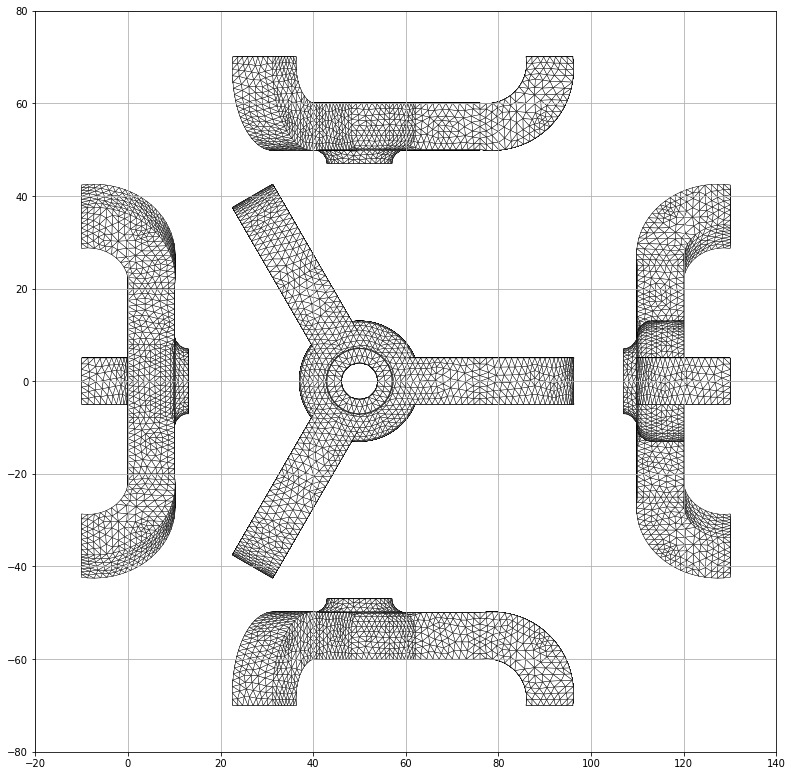

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import numpy as np

fig = plt.figure(figsize=(30, 30))

index1 = np.argsort((vertices[faces][:, :, 1]).mean(axis=1))
collection1 = PolyCollection(
    (vertices[faces][:, :, np.array([0, 2])] + [50.0, 0.0])[index1],
    closed=True,
    linewidth=0.4,
    facecolor="1.0",
    edgecolor="black",
)

index2 = np.argsort((vertices[faces][:, :, 2]).mean(axis=1))
collection2 = PolyCollection(
    (vertices[faces][:, :, np.array([0, 1])]*[1.0, 1.0] + [50.0, -60.0])[index2],
    closed=True,
    linewidth=0.4,
    facecolor="1.0",
    edgecolor="black",
)

index3 = np.argsort((vertices[faces][:, :, 0]).mean(axis=1))
collection3 = PolyCollection(
    (vertices[faces][:, :, np.array([1, 2])]*[-1.0, 1.0] + [120.0, 0.0])[index3],
    closed=True,
    linewidth=0.4,
    facecolor="1.0",
    edgecolor="black",
)

index4 = np.argsort((vertices[faces][:, :, 0]).mean(axis=1)*(-1.0))
collection4 = PolyCollection(
    (vertices[faces][:, :, np.array([1, 2])]*[1.0, 1.0] + [0.0, 0.0])[index4],
    closed=True,
    linewidth=0.4,
    facecolor="1.0",
    edgecolor="black",
)

index5 = np.argsort((vertices[faces][:, :, 2]).mean(axis=1)*(-1.0))
collection5 = PolyCollection(
    (vertices[faces][:, :, np.array([0, 1])]*[1.0, -1.0] + [50.0, 60.0])[index5],
    closed=True,
    linewidth=0.4,
    facecolor="1.0",
    edgecolor="black",
)

ax = fig.add_subplot(211)
ax.set_xlim(-20, 140)
ax.set_ylim(-80, +80)
ax.set_aspect(1)
ax.set_frame_on(True)
ax.add_collection(collection1)
ax.add_collection(collection2)
ax.add_collection(collection3)
ax.add_collection(collection4)
ax.add_collection(collection5)
ax.grid(True)
